In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Preprocessing

## Parameters

In [3]:
# parameters

_round_num = 3
# _symbol = "COCONUTS"
_symbol = "DIVING_GEAR"
# _day_ind = -2
_day_range = [0, 1, 2]
_book_range = list(range(1, 3+1))
_max_time = 1000000
_time_step = 100

In [4]:
def get_file_trades(day):
    fname = f"../data/round{_round_num}/trades_round_{_round_num}_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

## read data

In [5]:
def get_book_large_size(side, price_df):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df

In [43]:
# get data for each day
trades = []
prices = []

for day in _day_range:
    # get data from files
    trade_df = get_file_trades(day)
    price_df = get_file_prices(day)
    
    trade_df["day"] = day
    
    trades += [trade_df]
    prices += [price_df]

# concat all data
price_df = pd.concat(prices)
price_df = price_df.rename({"timestamp": "time"}, axis=1)
price_df["time"] = price_df["time"] + (price_df["day"] - min(_day_range)) * _max_time

price_df_diving = price_df[price_df['product'] == 'DIVING_GEAR']
price_df_dolphin = price_df[price_df['product'] == 'DOLPHIN_SIGHTINGS']


#get whale orders
diving_bid_whale = get_book_large_size('bid', price_df_diving)
diving_ask_whale = get_book_large_size('ask', price_df_diving)

#create Quote DF for diving
quote_df = pd.merge(diving_bid_whale, diving_ask_whale, on="time")
quote_df["mid_price"] = (quote_df["bid_price"] + quote_df["ask_price"]) / 2
quote_df["spread"] = quote_df["ask_price"] - quote_df["bid_price"]

quote_df['dolphin_sightings'] = list(price_df_dolphin['mid_price'])
quote_df = quote_df.filter(items=['mid_price', 'dolphin_sightings', 'time'])
quote_df

fname ../data/round3/trades_round_3_day_0_nn.csv
fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round3/trades_round_3_day_1_nn.csv
fname ../data/round3/prices_round_3_day_1.csv
fname ../data/round3/trades_round_3_day_2_nn.csv
fname ../data/round3/prices_round_3_day_2.csv


,mid_price,dolphin_sightings,time
0,100000.0,3000.0,0
1,100000.0,3000.0,100
2,100002.0,2999.0,200
3,100000.0,2999.0,300
4,99994.5,2999.0,400
...,...,...,...
29995,100174.5,3094.0,2999500
29996,100171.0,3094.0,2999600
29997,100179.5,3094.0,2999700
29998,100182.0,3094.0,2999800


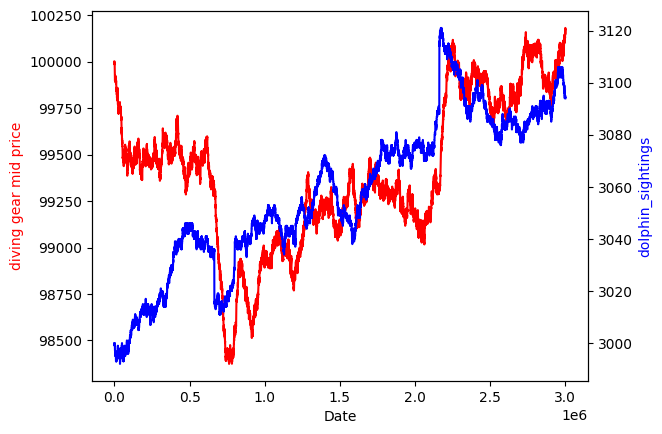

In [44]:
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot line for diving gear on first axis
ax1.plot(quote_df['time'], quote_df['mid_price'], color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('diving gear mid price', color='red')

# Create a second axis for dolphin sightings
ax2 = ax1.twinx()
ax2.plot(quote_df['time'], quote_df['dolphin_sightings'], color='blue')
ax2.set_ylabel('dolphin_sightings', color='blue')

# Show plot
plt.show()

In [103]:
quote_df['diving_diff'] = quote_df['mid_price'].diff()
quote_df['dolphin_diff'] = quote_df['dolphin_sightings'].diff()
# quote_df
# quote_df['diving_diff'] = quote_df['mid_price'].pct_change()
# quote_df['dolphin_diff'] = quote_df['dolphin_sightings'].pct_change()
# quote_df
lags = 20
quote_df_lags = quote_df.copy()
for i in range(1, lags):
    quote_df_lags[f'dolphin_diff_lag_{i}'] = quote_df_lags['dolphin_diff'].shift(i)
    

# drop first 20 rows so no NAN values
quote_df_lags = quote_df_lags.drop(quote_df_lags.index[:20])
quote_df_lags = quote_df_lags[abs(quote_df_lags['diving_diff']) > 1]
# quote_df_lags = quote_df_lags[abs(quote_df_lags['diving_diff']) > 0.000015]

quote_df_lags.corr()
# quote_df_lags.head(30)
# quote_df.head(40)


,mid_price,dolphin_sightings,time,diving_diff,dolphin_diff,dolphin_diff_lag_1,dolphin_diff_lag_2,dolphin_diff_lag_3,dolphin_diff_lag_4,dolphin_diff_lag_5,...,dolphin_diff_lag_10,dolphin_diff_lag_11,dolphin_diff_lag_12,dolphin_diff_lag_13,dolphin_diff_lag_14,dolphin_diff_lag_15,dolphin_diff_lag_16,dolphin_diff_lag_17,dolphin_diff_lag_18,dolphin_diff_lag_19
mid_price,1.000000,0.510382,0.519726,0.010969,-0.009252,-0.009349,-0.011248,-0.004217,-0.006102,-0.008182,...,-0.003973,-0.006321,-0.004621,-0.002979,-0.009956,-0.001898,-0.012455,-0.003471,-0.006373,-0.008899
dolphin_sightings,0.510382,1.000000,0.925331,0.020043,0.003433,-0.000420,-0.002274,0.001935,0.007015,-0.000086,...,0.003737,-0.002021,0.002002,0.001381,-0.000671,0.006436,-0.002706,0.004732,0.002026,-0.000638
time,0.519726,0.925331,1.000000,0.013837,-0.005043,-0.005241,-0.007695,-0.001566,0.001272,-0.004977,...,-0.000609,-0.003501,-0.003231,-0.002839,-0.004710,0.002194,-0.006276,-0.002400,-0.003085,-0.004333
diving_diff,0.010969,0.020043,0.013837,1.000000,-0.005794,-0.002336,0.000803,0.002244,-0.000994,0.003342,...,0.015398,0.001328,-0.002792,0.005564,-0.006967,-0.005161,-0.003562,0.005122,-0.003290,0.002629
dolphin_diff,-0.009252,0.003433,-0.005043,-0.005794,1.000000,-0.233323,-0.044460,0.009508,-0.003677,-0.001224,...,0.004140,-0.001613,0.002213,-0.003821,0.006344,0.000258,0.001935,0.003344,-0.002292,0.000265
dolphin_diff_lag_1,-0.009349,-0.000420,-0.005241,-0.002336,-0.233323,1.000000,-0.227134,-0.042770,0.010089,-0.006613,...,-0.003939,-0.001999,0.003228,0.004747,-0.003579,0.003070,0.004695,0.003306,0.004398,-0.004615
dolphin_diff_lag_2,-0.011248,-0.002274,-0.007695,0.000803,-0.044460,-0.227134,1.000000,-0.228952,-0.038221,0.007302,...,-0.003878,0.000114,-0.002083,0.002534,0.003143,-0.003399,0.007158,0.003840,0.000546,0.005798
dolphin_diff_lag_3,-0.004217,0.001935,-0.001566,0.002244,0.009508,-0.042770,-0.228952,1.000000,-0.228720,-0.042155,...,-0.009684,-0.001236,-0.001460,0.001527,0.000279,0.001832,-0.004209,0.004100,0.005032,0.002851
dolphin_diff_lag_4,-0.006102,0.007015,0.001272,-0.000994,-0.003677,0.010089,-0.038221,-0.228720,1.000000,-0.219923,...,0.002900,-0.011835,-0.001487,-0.004707,-0.002860,0.005922,0.000388,-0.006544,0.003110,0.006385
dolphin_diff_lag_5,-0.008182,-0.000086,-0.004977,0.003342,-0.001224,-0.006613,0.007302,-0.042155,-0.219923,1.000000,...,0.007835,0.002547,-0.010442,-0.003903,0.001171,-0.000736,0.001567,0.000709,0.001132,0.002126


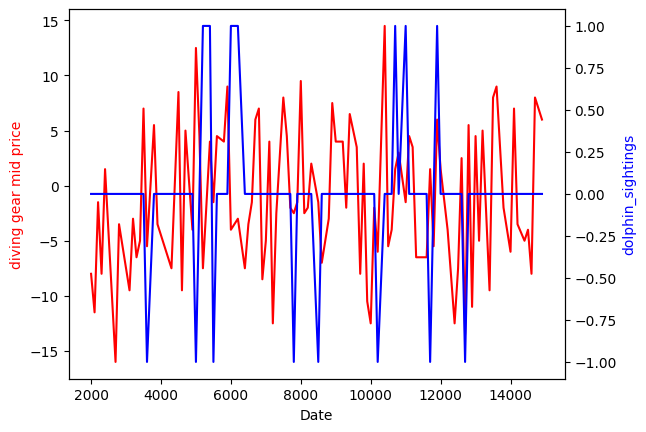

In [104]:

quote_df_lags = quote_df_lags.head(100)
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot line for diving gear diff on first axis
ax1.plot(quote_df_lags['time'], quote_df_lags['diving_diff'], color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('diving gear mid price', color='red')

# Create a second axis for dolphin sightings diff
ax2 = ax1.twinx()
ax2.plot(quote_df_lags['time'], quote_df_lags['dolphin_diff_lag_1'], color='blue')
ax2.set_ylabel('dolphin_sightings', color='blue')

# Show plot
plt.show()